In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import inspect
import matplotlib
from matplotlib import rcParams

import pandas as pd
import numpy as np

from cls2 import occur, plotting
from cls2.occur import *
from cls2.io import *

from radvel.utils import geterr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
sysprops = pd.read_csv('legacy_tables/system_props.csv')

In [20]:
specmatch = pd.read_csv('legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [21]:
objects = pd.read_csv('legacy_tables/planet_list.csv')
trends = pd.read_csv('legacy_tables/trend_list.csv')

In [22]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [23]:
recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [24]:
samples_all = pd.read_csv('samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

columns_good = []
for planet in planetnames:
    # remove 114762 b/c found to be face-on binary Keifer et al. (2019)
    if '114762' in planet:
        continue
    
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.02) and (samples_med[M_col] > 0.09):
        columns_good.append(a_col)
        columns_good.append(M_col)
        
samples_all = samples_all[columns_good]

for col in columns_good:
    if '_M' in col:
        samples_all[col] *= 317.8

In [25]:
broken = BrokenPowerLaw(samples_all, completey_all)
broken.max_like()

In [26]:
broken.sample(parallel=False, nsamples=1000)

100%|██████████| 1000/1000 [17:20<00:00,  1.04s/it]


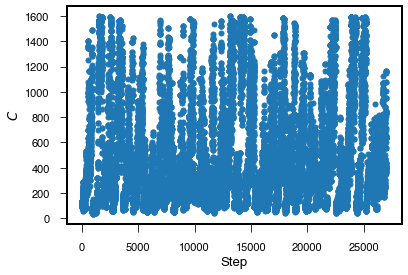

In [27]:
plotting.mcmc_trend(broken)

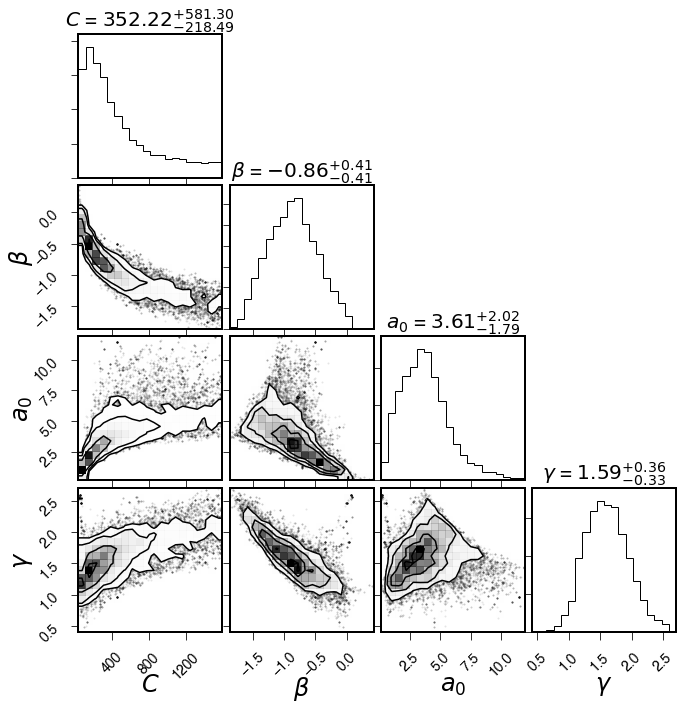

In [88]:
f = rcParams['font.size']
rcParams['font.size'] = 14
fig = corner.corner(broken.chains, labels = [r'$C$', r'$\beta$', r'$a_0$', r'$\gamma$'], 
                    show_titles=True, label_kwargs=dict(fontsize=24))
fig.savefig('plots/corner_broken_powerlaw.pdf')

rcParams['font.size'] = f

In [46]:
pars = ['C', 'beta', 'a0', 'gamma', 'power_in']

broken_chains = pd.read_csv('powerlaw_chains.csv')
broken_chains['power_in'] = broken_chains['beta'] + broken_chains['gamma']

for par in pars:
    param = geterr(broken_chains[par])
    print(param)
    

(352.2171021202302, 218.96081575909835, 584.9828124423439)
(-0.8609438296860221, 0.4120522361224197, 0.40694682549050154)
(3.605135608782398, 1.7968158273663293, 2.0298658470781166)
(1.589668024090083, 0.32974989262444665, 0.35854554330377475)
(0.704044543331726, 0.16748570439548893, 0.23304297963825027)


In [50]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_one = Hierarchy(samples_all, completey_all, bins=allbins, chainname='occur_chains.csv')
hierarchical_one.max_like()

In [51]:
hierarchical_one.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [41:53<00:00,  2.51s/it]


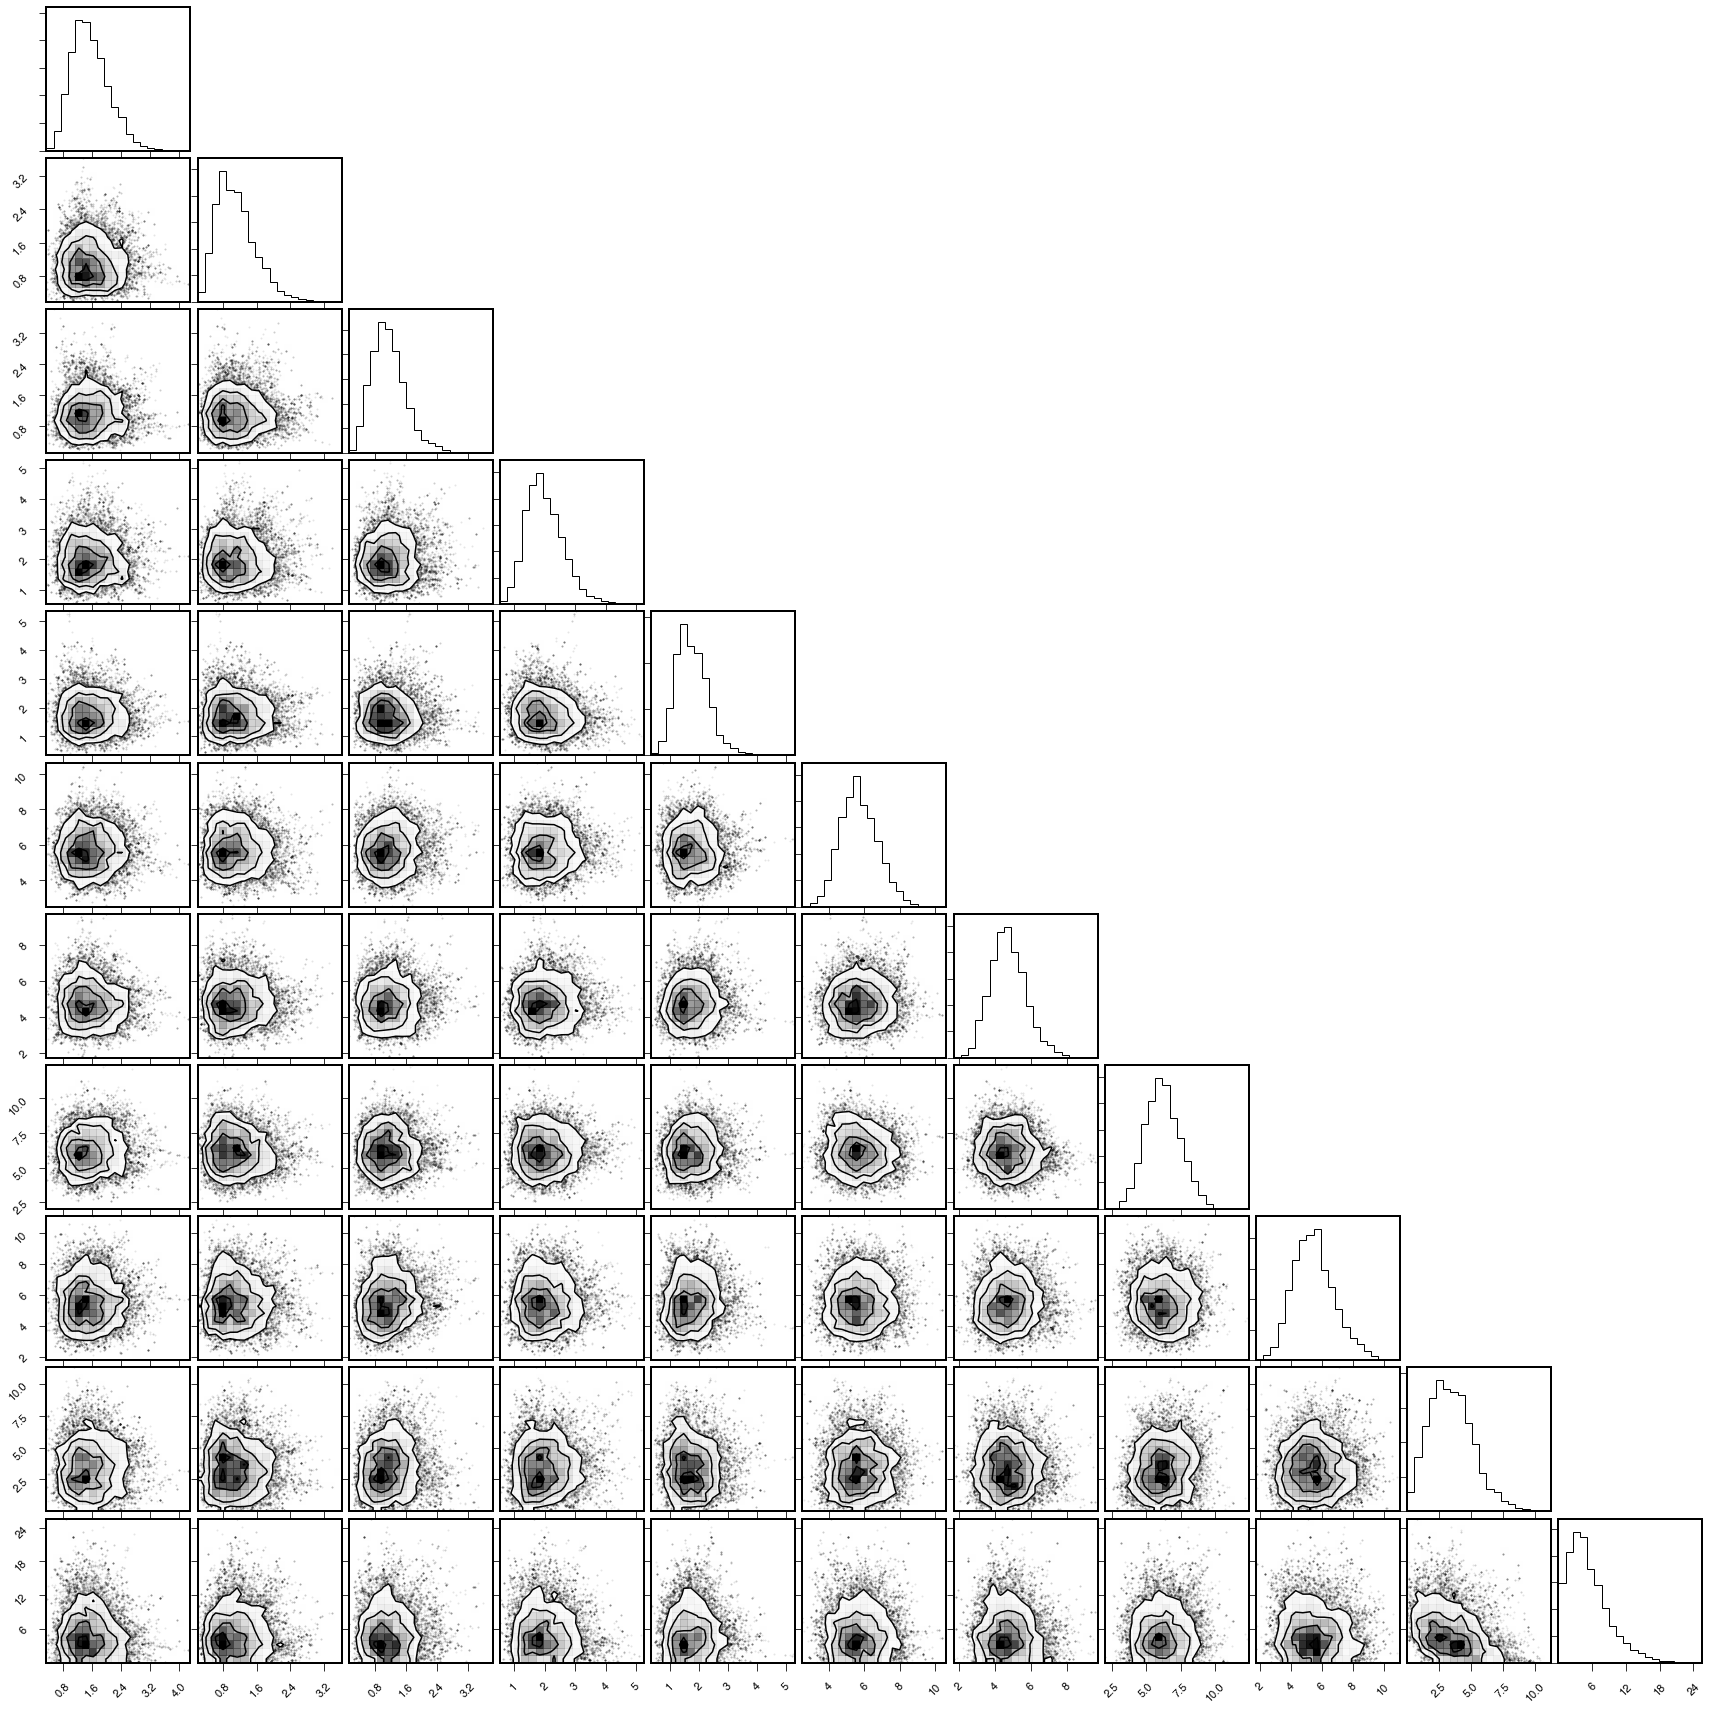

In [52]:
fig = corner.corner(hierarchical_one.chains[10000:]*hierarchical_one.bin_areas[0][0]*(100/719))
fig.savefig('plots/corner_11x1_1014.pdf')

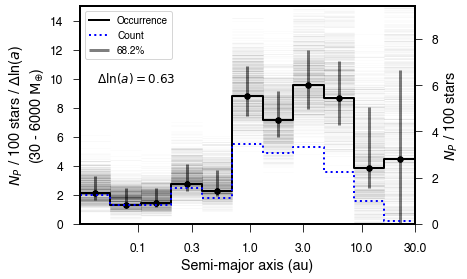

In [53]:
plotting.binned_hist(planets, allbins, hierarchical_one)

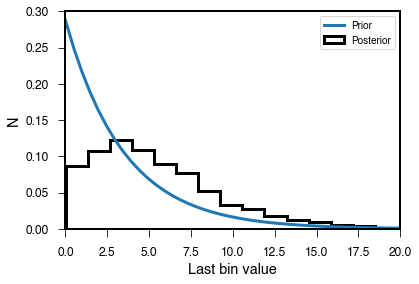

In [54]:
plotting.last_bin(hierarchical_one, chains_file='occur_chains.csv')

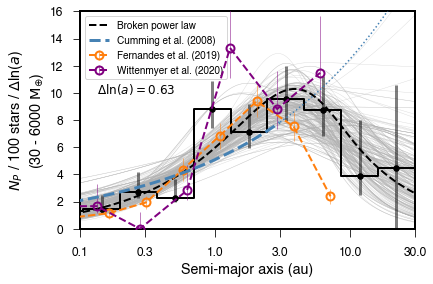

In [77]:
plotting.fit_overlay(planets, hierarchical_one, broken, allbins,
                     chains_file='occur_chains.csv',
                     outname='plots/hist_11x1_1014_hierarchy_and_broken.pdf', show_others=True)

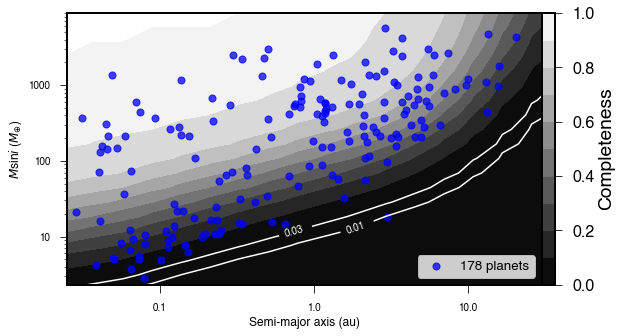

In [25]:
plotting.survey_summary(planets)

In [160]:
bins = lngrid(10, 50., 300, 6000, 1, 1) 
hierarchical_onebin = Hierarchy(samples_all, completey_all, bins=bins, chainname='biller_comp_chains.csv')
hierarchical_onebin.max_like()

In [161]:
hierarchical_onebin.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]


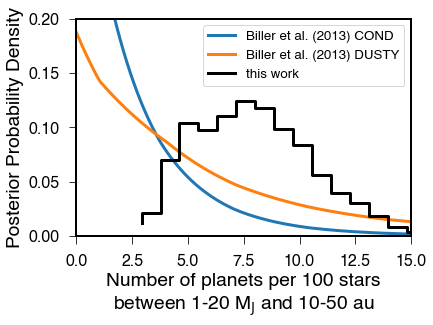

In [162]:
from scipy import interpolate

chains_db = pd.read_csv('biller_comp_chains.csv')

biller_cond = pd.read_csv('biller_cond.csv', names=['x', 'y'])
biller_cond['f'] = np.exp(biller_cond['y'])
x = np.linspace(0, 30, 200)
iy = scipy.interpolate.interp1d(biller_cond['x']*100, biller_cond['y'])
fc = np.exp(iy(x))
fc = fc / np.trapz(fc, x, dx=np.diff(x))

biller_dusty = pd.read_csv('biller_dusty.csv', names=['x', 'y'])
biller_dusty['f'] = np.exp(biller_dusty['y']) / np.sum(np.exp(biller_dusty['y']))
iy = scipy.interpolate.interp1d(biller_dusty['x']*100, biller_dusty['y'])
fd = np.exp(iy(x))
fd = fd / np.trapz(fd, x, dx=np.diff(x))


fig, ax = plt.subplots()
factor = hierarchical_onebin.bin_areas[0][0]*(100/719)
bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

prior_grid = np.linspace(0, 4*hierarchical_onebin.ceiling*factor, num=50)
ax.plot(x, fc, lw=3, label='Biller et al. (2013) COND')
ax.plot(x, fd, lw=3, label='Biller et al. (2013) DUSTY')

# ax.hist(factor*chains_db['gamma0'][1000:], bins=20, density=True, fill=False, 
#         histtype='step', color='black', lw=3, label='this work')
plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 15])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 1-20 M$_{\\rm J}$ and 10-50 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('biller_comp.pdf', dpi=1000, bbox_inches='tight')

In [163]:
bins = lngrid(10, 100., 300*5, 300*13, 1, 1) 
hierarchical_nielbin = Hierarchy(samples_all, completey_all, bins=bins, chainname='di_comp_chains.csv')
hierarchical_nielbin.max_like()
hierarchical_nielbin.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s]


0.5826770498425191


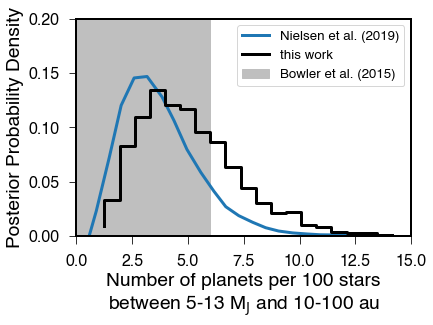

In [164]:
chains_db = pd.read_csv('di_comp_chains.csv')

nielsen = pd.read_csv('nielsen.csv', names=['x', 'y'])
nielsen['f'] = nielsen['y'] / np.sum(nielsen['y'])
print(np.trapz(nielsen['f'], nielsen['x'], dx=np.diff(nielsen['x'])))

fig, ax = plt.subplots()
factor = hierarchical_nielbin.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_nielbin.ceiling*factor, num=50)
ax.plot(nielsen['x'], nielsen['f'], lw=3, label='Nielsen et al. (2019)')

ax.axvspan(0, 6, label='Bowler et al. (2015)', color='0.75')

bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 15])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 5-13 M$_{\\rm J}$ and 10-100 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('nielsen_comp.pdf', dpi=1000, bbox_inches='tight')

In [165]:
cassan_bin = lngrid(0.5, 10., 100., 3000, 1, 1)

hierarchical_cas = Hierarchy(samples_all, completey_all, bins=cassan_bin, chainname='cassan_comp_chains.csv')
hierarchical_cas.max_like()
hierarchical_cas.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


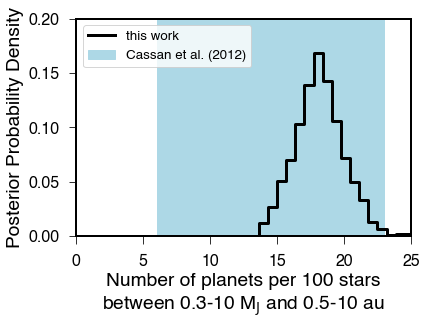

In [166]:
chains_db = pd.read_csv('cassan_comp_chains.csv')

fig, ax = plt.subplots()
factor = hierarchical_cas.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_cas.ceiling*factor, num=50)
ax.axvspan(6, 23, label='Cassan et al. (2012)', color='lightblue')

bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 25])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 0.3-10 M$_{\\rm J}$ and 0.5-10 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('cassan_comp.pdf', dpi=1000, bbox_inches='tight')

In [167]:
clanton_bin = lngrid(1.55, 7.2, 100., 1000, 1, 1)

hierarchical_cla = Hierarchy(samples_all, completey_all, bins=clanton_bin, chainname='clanton_comp_chains.csv')
hierarchical_cla.max_like()
hierarchical_cla.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


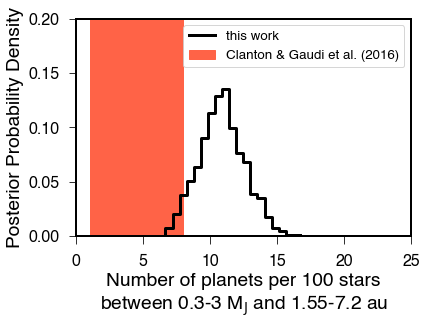

In [168]:
chains_db = pd.read_csv('clanton_comp_chains.csv')

fig, ax = plt.subplots()
factor = hierarchical_cla.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_cla.ceiling*factor, num=50)
ax.axvspan(1, 8, label='Clanton & Gaudi et al. (2016)', color='tomato')

bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 25])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 0.3-3 M$_{\\rm J}$ and 1.55-7.2 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('clanton_comp.pdf', dpi=1000, bbox_inches='tight')

In [8]:
subjupbins = lngrid(0.03, 30., 30., 300, 11, 1) 
supjupbins = lngrid(0.03, 30., 300., 6000, 11, 1) 
hierarchical_sub = Hierarchy(samples_all, completey_all, bins=subjupbins[:-2],
                             chainname='occur_chains_11x1_sub.csv')
hierarchical_sup = Hierarchy(samples_all, completey_all, bins=supjupbins,
                             chainname='occur_chains_11x1_sup.csv')
hierarchical_sub.max_like()
hierarchical_sup.max_like()
hierarchical_sub.sample(parallel=False, gp=False)
hierarchical_sup.sample(parallel=False, gp=False)




100%|██████████| 1000/1000 [37:59<00:00,  2.28s/it]


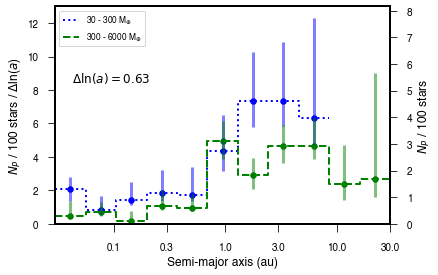

In [10]:
plotting.subjovians(hierarchical_sub, hierarchical_sup, subjupbins, supjupbins)